**Import nesscessary libraries**

In [1]:
!pip install pyspark

In [2]:
import pandas as pnd
import matplotlib.pyplot as pyplt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
import warnings
from pyspark.sql.functions import col, when, sum, avg, lit, udf, count
from pyspark.sql.types import StringType
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [5]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

**Data Loading**

In [7]:
spark_df = spark.read.load('/content/drive/MyDrive/anime.csv', format='csv', inferSchema=True, header=True)

In [8]:
pandas_df = spark_df.select(*spark_df.columns).toPandas()

In [9]:
DatasetAnime_=pandas_df

**Data Preprocessing**

In [10]:
AnimeDataCols_ = ['Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
                 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1',
                 'Ranked', 'Popularity', 'Completed']

In [11]:
for c in AnimeDataCols_:
    DatasetAnime_[c] = pnd.to_numeric(DatasetAnime_[c], errors='coerce')
    DatasetAnime_[c].fillna(DatasetAnime_[c].median(), inplace=True)

In [12]:
DatasetAnime_

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,...,39.0,71.0,92.0,1.0,144.0,111.0,50.0,27.0,18.0,16.0
17558,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,...,39.0,71.0,92.0,140.0,144.0,111.0,50.0,27.0,18.0,16.0
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,...,1.0,71.0,92.0,140.0,144.0,111.0,50.0,27.0,18.0,16.0
17560,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,TV,Unknown,Unknown,Unknown,...,39.0,71.0,92.0,140.0,144.0,111.0,50.0,27.0,18.0,16.0


In [13]:
Getweights = [w for w in range(1, 11)]
Cal_WeightedScores = DatasetAnime_[[f"Score-{i}" for i in range(1, 11)]] * Getweights
calSumScores = Cal_WeightedScores.sum(axis=1)
NoOfVotes_ = DatasetAnime_[[f"Score-{i}" for i in range(1, 11)]].sum(axis=1)

In [14]:
DatasetAnime_['Score'] = pnd.to_numeric(DatasetAnime_['Score'], errors='coerce')  # Convert scores handling 'Unknown'
DatasetAnime_['Score'] = DatasetAnime_['Score'].fillna(calSumScores / NoOfVotes_)

In [15]:
DatasetAnime_.describe()

,MAL_ID,Score,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
count,17562.000000,17562.000000,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,...,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000,17562.000000
mean,21477.192347,6.467733,7895.265061,8763.310158,3.465288e+04,466.320351,2230.630110,2.209341e+04,957.526022,1175.829404,...,2485.589853,3213.917435,4475.432069,3886.391470,1911.342045,961.323255,431.250427,199.076984,118.421478,120.295012
std,14900.093170,0.935869,4322.265280,5058.795205,1.252810e+05,4148.767095,14046.470179,9.100923e+04,4285.969718,4737.983462,...,16873.305503,18069.198794,19818.716122,14083.802311,6374.781294,3206.006256,1702.203497,845.540364,548.103372,666.039677
min,1.000000,1.850000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5953.500000,5.850000,4390.000000,4385.250000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,...,7.000000,11.000000,9.000000,12.000000,17.000000,20.000000,11.000000,8.000000,6.000000,6.000000
50%,22820.000000,6.500000,7896.000000,8762.500000,2.065500e+03,3.000000,73.000000,8.170000e+02,45.000000,77.000000,...,39.000000,71.000000,92.000000,140.000000,144.000000,111.000000,50.000000,27.000000,18.000000,16.000000
75%,35624.750000,7.146341,11408.000000,13145.000000,1.322050e+04,31.000000,521.000000,6.476500e+03,292.000000,271.000000,...,357.750000,394.000000,834.750000,1261.000000,858.000000,488.750000,189.000000,91.000000,54.000000,53.000000
max,48492.000000,9.190000,15780.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,...,714811.000000,535252.000000,459113.000000,303813.000000,188431.000000,124819.000000,81155.000000,44204.000000,25371.000000,33750.000000


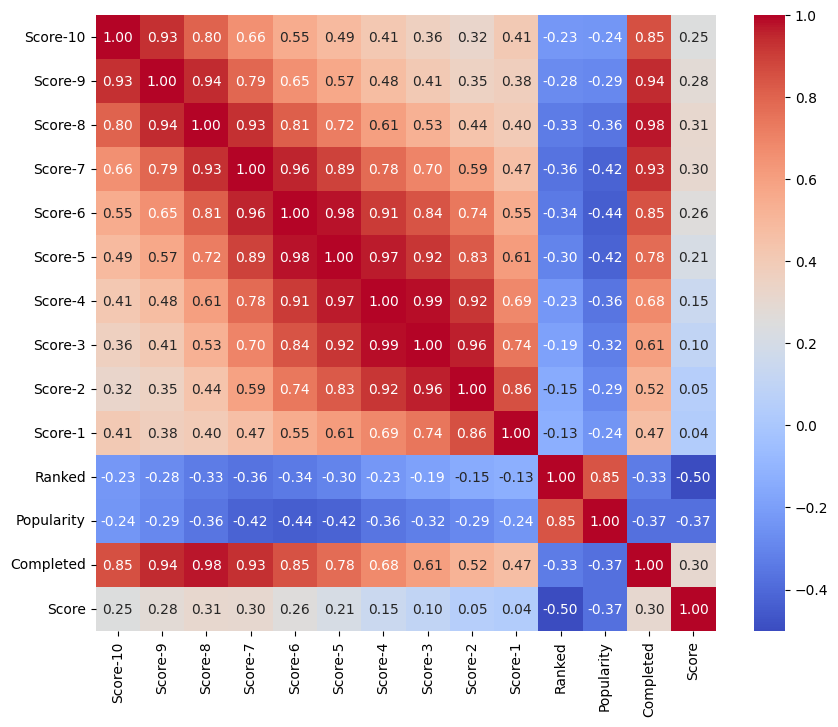

In [16]:
FeatureCorr = DatasetAnime_[AnimeDataCols_ + ['Score']].corr()
pyplt.figure(figsize=(10, 8))
sb.heatmap(FeatureCorr, annot=True, fmt=".2f", cmap='coolwarm')
pyplt.show()

**Data Visualisations**

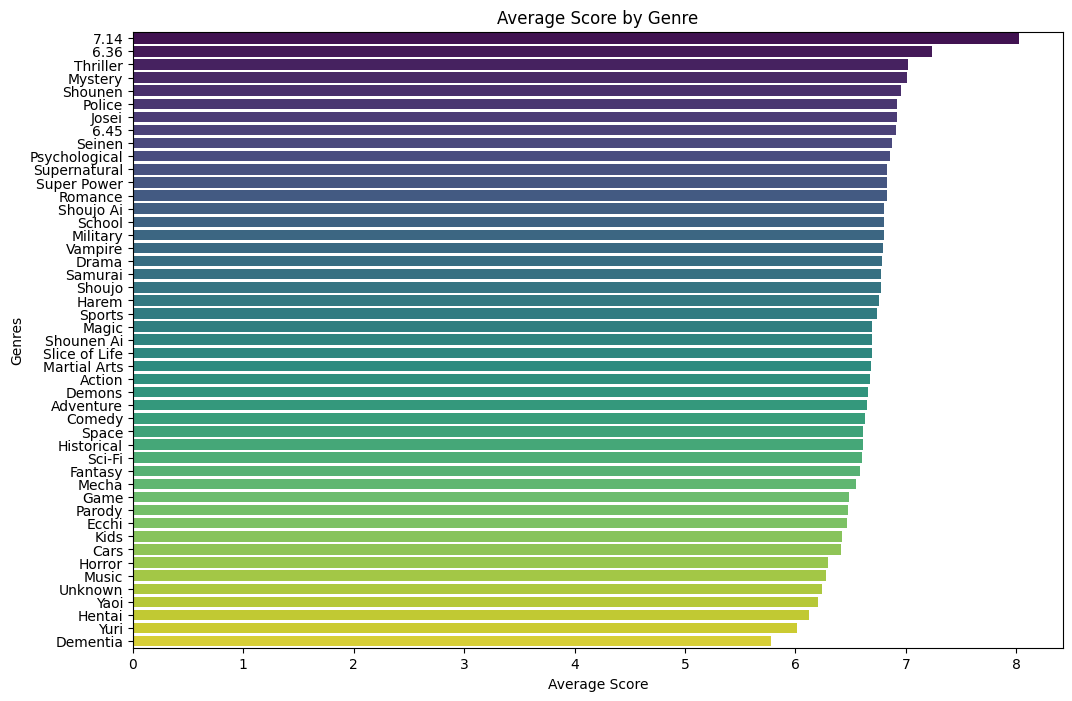

In [17]:
# Genres vs. Score
DF_Genre = DatasetAnime_.assign(Genres=DatasetAnime_['Genres'].str.split(', ')).explode('Genres')
calScores_genre = DF_Genre.groupby('Genres')['Score'].mean().sort_values(ascending=False)
pyplt.figure(figsize=(12, 8))
sb.barplot(x=calScores_genre.values, y=calScores_genre.index, palette='viridis')
pyplt.xlabel('Average Score')
pyplt.ylabel('Genres')
pyplt.title('Average Score by Genre')
pyplt.show()



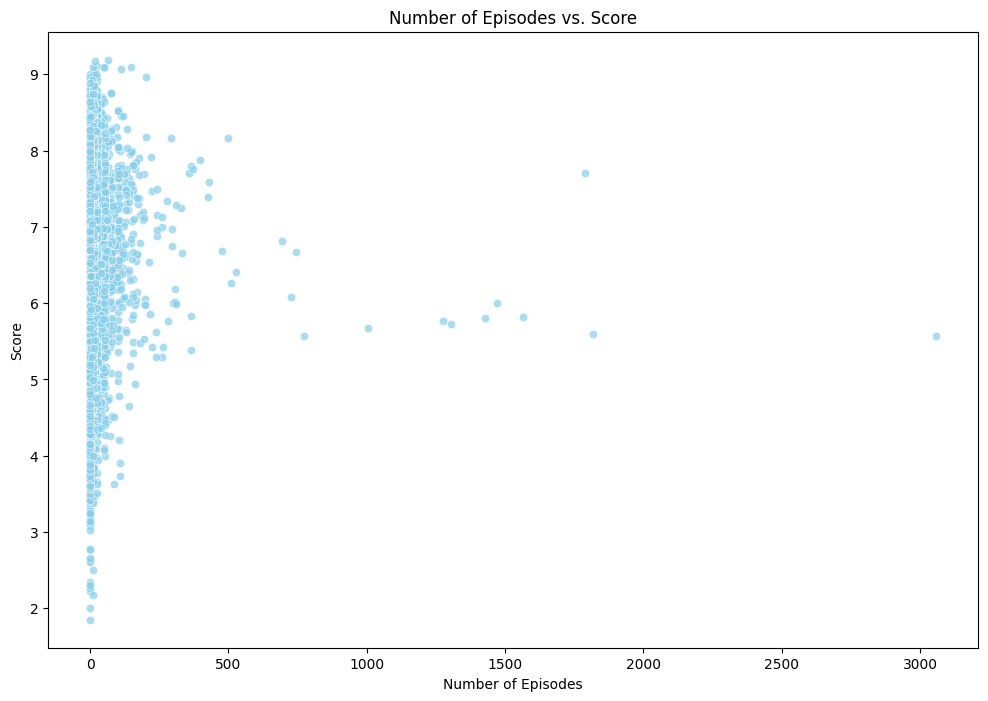

In [18]:
# Episodes vs. Score
#EpisodesDF = DatasetAnime_[DatasetAnime_['Episodes'] != 'Unknown']
#EpisodesDF['Episodes'] = EpisodesDF['Episodes'].astype(int)
#pyplt.figure(figsize=(12, 8))
#sb.scatterplot(x='Episodes', y='Score', data=EpisodesDF, alpha=0.7, color='skyblue')
#pyplt.xlabel('Number of Episodes')
#pyplt.ylabel('Score')
#pyplt.title('Number of Episodes vs. Score')
#pyplt.show()
EpisodesDF = DatasetAnime_[DatasetAnime_['Episodes'].astype(str).str.isnumeric()]
EpisodesDF['Episodes'] = EpisodesDF['Episodes'].astype(int)
pyplt.figure(figsize=(12, 8))
sb.scatterplot(x='Episodes', y='Score', data=EpisodesDF, alpha=0.7, color='skyblue')
pyplt.xlabel('Number of Episodes')
pyplt.ylabel('Score')
pyplt.title('Number of Episodes vs. Score')
pyplt.show()

In [19]:
# Premiered vs. Score
premieredAndScores = DatasetAnime_.groupby('Premiered')['Score'].mean().sort_values(ascending=False)
premieredAndScores

Premiered
1                              8.260870
Oct 6, 2018 to Mar 30, 2019    8.020740
Summer 1991                    7.790000
Winter 1985                    7.680000
Winter 1993                    7.370000
                                 ...   
Summer 1966                    5.469507
Spring 1965                    5.436279
Spring 1964                    5.417219
Summer 1967                    5.282609
Winter 1965                    5.142157
Name: Score, Length: 236, dtype: float64

**Prepare data for modeling**

In [20]:
featuresX = DatasetAnime_[AnimeDataCols_]  # features
targety = DatasetAnime_['Score']        # target

**Split data**

In [21]:
TrainAnime_X, TestAnime_X, TrainAnimeY, TestAnime_y = train_test_split(featuresX, targety, test_size=0.2, random_state=42)

**Model Train and Testing**

**1.OLS**

**2.LinearRegression**

**3.Ridge**

**4.Lasso**

**Feature Scaling**

In [22]:
s = StandardScaler()
ScaledTrainX = s.fit_transform(TrainAnime_X)
ScaledTestX = s.transform(TestAnime_X)

In [23]:
All_Models = {
    "OLS": sm.OLS(TrainAnimeY, sm.add_constant(ScaledTrainX)).fit(),
    "LinearRegression": LinearRegression().fit(ScaledTrainX, TrainAnimeY),
    "Ridge": Ridge().fit(ScaledTrainX, TrainAnimeY),
    "Lasso": Lasso().fit(ScaledTrainX, TrainAnimeY)
}

**Model Evaluations**

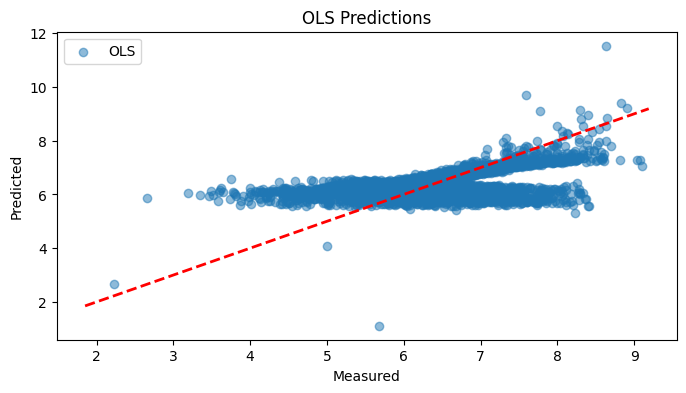

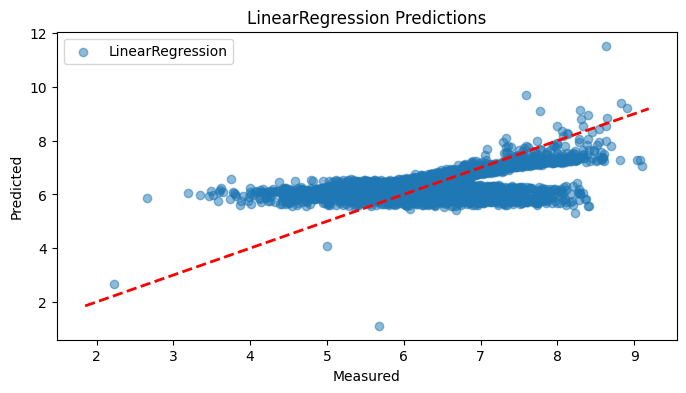

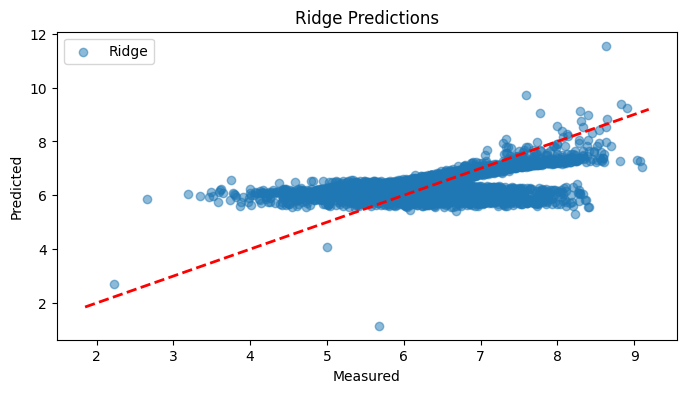

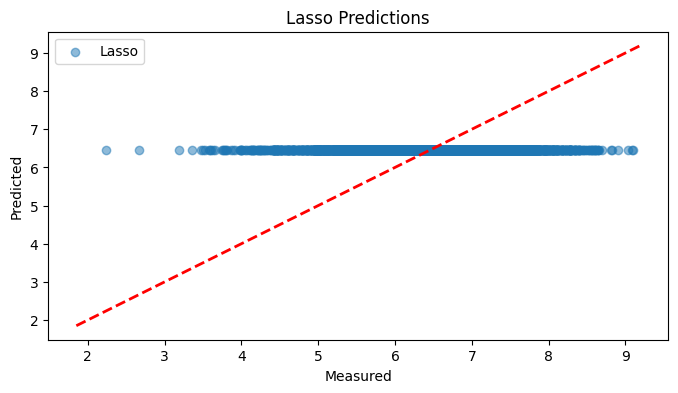

In [24]:
All_models_results = {}
for n, model in All_Models.items():
    if n == "OLS":
        pred = model.predict(sm.add_constant(ScaledTestX))
    else:
        pred = model.predict(ScaledTestX)

    cal_mse = mean_squared_error(TestAnime_y, pred)
    cal_mae = mean_absolute_error(TestAnime_y, pred)
    cal_rmse = np.sqrt(cal_mse)
    cal_r2 = r2_score(TestAnime_y, pred)
    All_models_results[n] = {"MSE": cal_mse, "MAE": cal_mae, "RMSE": cal_rmse, "R2": cal_r2}

    # Plot pred
    pyplt.figure(figsize=(8, 4))
    pyplt.scatter(TestAnime_y, pred, alpha=0.5, label=n)
    pyplt.plot([targety.min(), targety.max()], [targety.min(), targety.max()], 'r--', lw=2)
    pyplt.xlabel('Measured')
    pyplt.ylabel('Predicted')
    pyplt.title(f'{n} Predictions')
    pyplt.legend()
    pyplt.show()

**OLS summary and all results**

In [25]:
print(All_Models['OLS'].summary())
for n, result in All_models_results.items():
    print(f"{n} models_results:")
    print(f"  MSE: {result['MSE']:.3f}")
    print(f"  MAE: {result['MAE']:.3f}")
    print(f"  RMSE: {result['RMSE']:.3f}")
    print(f"  R2: {result['R2']:.3f}\n")

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     463.0
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:16:34   Log-Likelihood:                -16523.
No. Observations:               14049   AIC:                         3.307e+04
Df Residuals:                   14035   BIC:                         3.318e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4676      0.007    976.797      0.0

**Multiple linear regression**


In [26]:
numericalDF_Cols = ['Episodes', 'Score']
for c in numericalDF_Cols:
    DatasetAnime_[c] = pnd.to_numeric(DatasetAnime_[c], errors='coerce')
    median_value = DatasetAnime_[c].median()
    DatasetAnime_[c].fillna(median_value, inplace=True)

In [27]:
Cat_Cols = ['Name', 'Genres', 'English name', 'Japanese name', 'Type', 'Aired', 'Premiered']
for col in Cat_Cols:
    DatasetAnime_ = DatasetAnime_[DatasetAnime_[col] != 'Unknown']

In [28]:
df_Cat = pnd.get_dummies(DatasetAnime_[Cat_Cols], drop_first=True)
DF_features = pnd.concat([DatasetAnime_[['MAL_ID', 'Score', 'Episodes']], df_Cat], axis=1)
X_cat = DF_features.drop('Score', axis=1)
y_cat = DF_features['Score']

In [29]:
TrainAnime_X_cat, TestAnime_X_cat, TrainAnimeY_cat, TestAnime_y_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
# Standardizing the features
scaler_cat = StandardScaler()
ScaledTrainX_cat = scaler_cat.fit_transform(TrainAnime_X_cat)
ScaledTestX_cat = scaler_cat.transform(TestAnime_X_cat)

In [30]:
# Fitting the linear regression model
model_cat = LinearRegression()
model_cat.fit(ScaledTrainX_cat, TrainAnimeY_cat)

LinearRegression()

In [31]:
coefficients_cat = model_cat.coef_
intercept_cat = model_cat.intercept_
feature_names_cat = X_cat.columns

In [32]:
print("coefficients_cat:", coefficients_cat)
print("Intercept:", intercept_cat)

coefficients_cat: [-0.0129012  -0.00217813  0.00283575 ...  0.00207005  0.0012486
 -0.00016548]
Intercept: 6.983713304273228


In [33]:
Multi_regr = LinearRegression()
Multi_regr.fit(ScaledTrainX, TrainAnimeY)

LinearRegression()

In [34]:
print("Coefficients:")
for c, cff in zip(TrainAnime_X.columns, Multi_regr.coef_):
    print(c, cff)
print("Intercept:", Multi_regr.intercept_)

Coefficients:
Score-10 0.09768858517627906
Score-9 -0.008493879120833638
Score-8 0.25607518458188017
Score-7 -0.46223845829619165
Score-6 1.0171562039900823
Score-5 -0.5158613873686239
Score-4 -0.2696070495845141
Score-3 0.36284312374203
Score-2 -0.18294187363254813
Score-1 -0.04010405642652286
Ranked -0.5692702611443886
Popularity 0.1938617141559125
Completed -0.11240443800876739
Intercept: 6.467579921376432


**Importance of Features for All Predictors**

In [35]:
def plotAllImp_Features(mod, featNames):
    imp = mod.coef_
    pyplt.figure(figsize=(10, 6))
    pyplt.barh(featNames, imp, color='skyblue')
    pyplt.xlabel('Coefficient Magnitude')
    pyplt.ylabel('Features')
    pyplt.title('Importance of Features for All Predictors')
    pyplt.gca().invert_yaxis()
    pyplt.show()


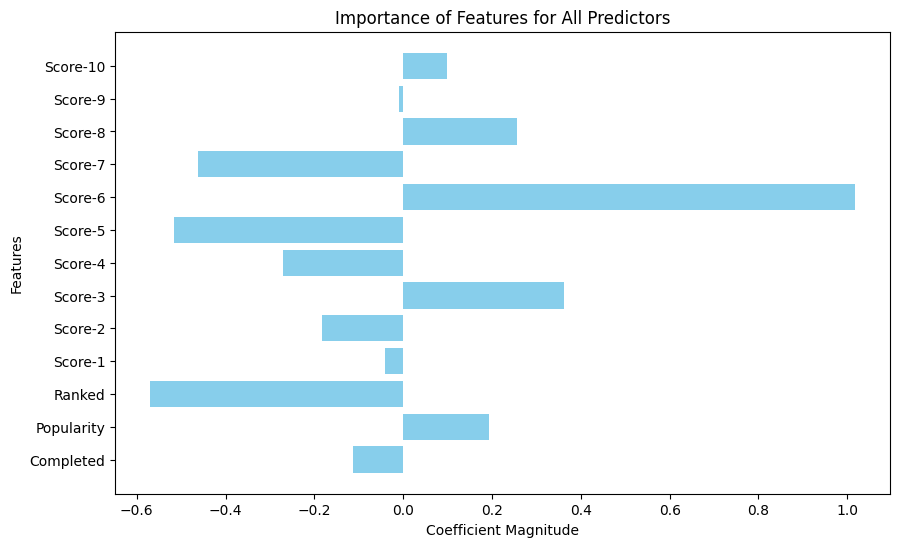

In [36]:
#Linear Regression Model
plotAllImp_Features(All_Models['LinearRegression'], AnimeDataCols_)

**show the most important features on top**

In [37]:
def plotFeaturesImp(model, featNames, title):
    coeff_cl = pnd.DataFrame({'Feature': featNames, 'Coefficient': model.coef_})
    coeff_cl.sort_values(by='Coefficient', ascending=False, inplace=True)

    pyplt.figure(figsize=(10, 6))
    pyplt.barh(coeff_cl['Feature'], coeff_cl['Coefficient'], color='green')
    pyplt.xlabel('Coefficient Value')
    pyplt.ylabel('Features')
    pyplt.title(title)
    pyplt.grid(axis='x')
    pyplt.gca().invert_yaxis()
    pyplt.show()

**Linear Regression Model with Excluded 'Type' and 'Source'**

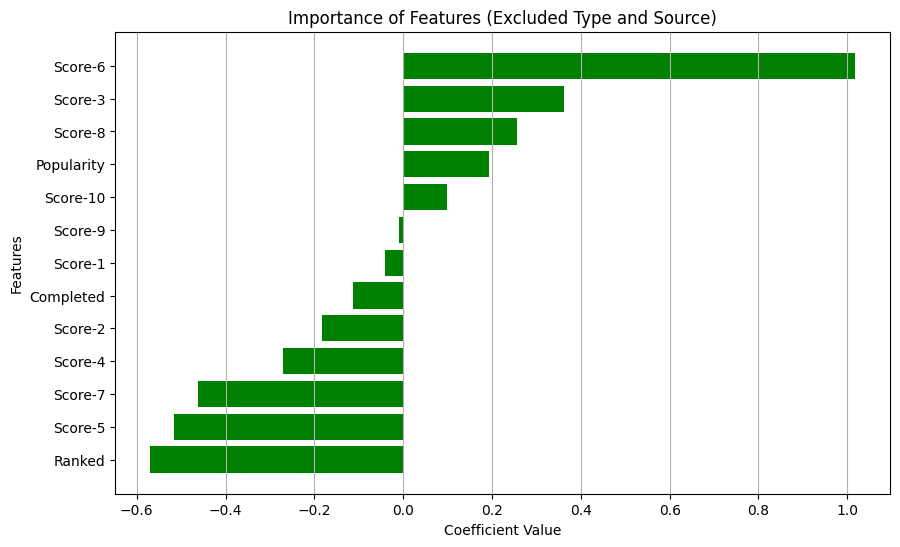

In [38]:
ex_features = ['Type', 'Source']
plotFeaturesImp(All_Models['LinearRegression'], AnimeDataCols_, 'Importance of Features (Excluded Type and Source)')

**Ridge Regression Model**


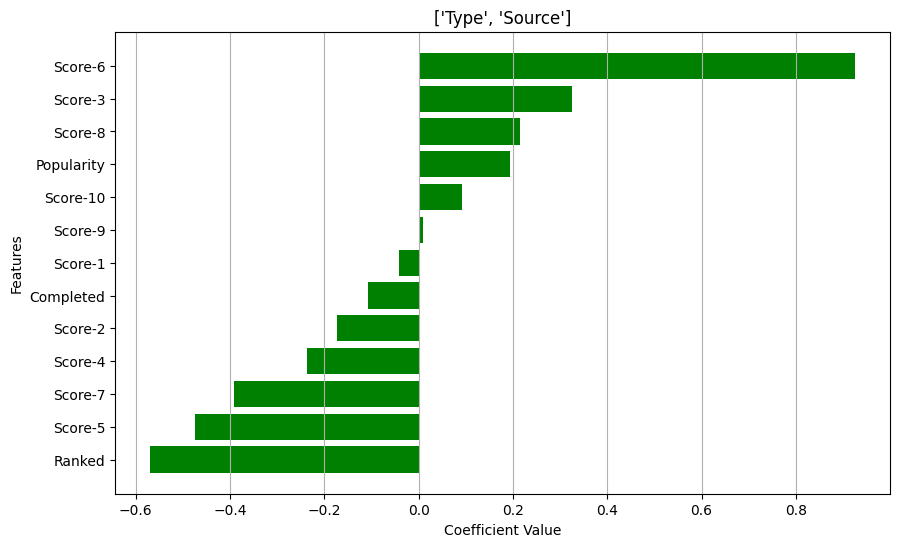

In [39]:
ex_features = ['Type', 'Source']
plotFeaturesImp(All_Models['Ridge'], AnimeDataCols_, ex_features)

**All Models Results and Comparisons**

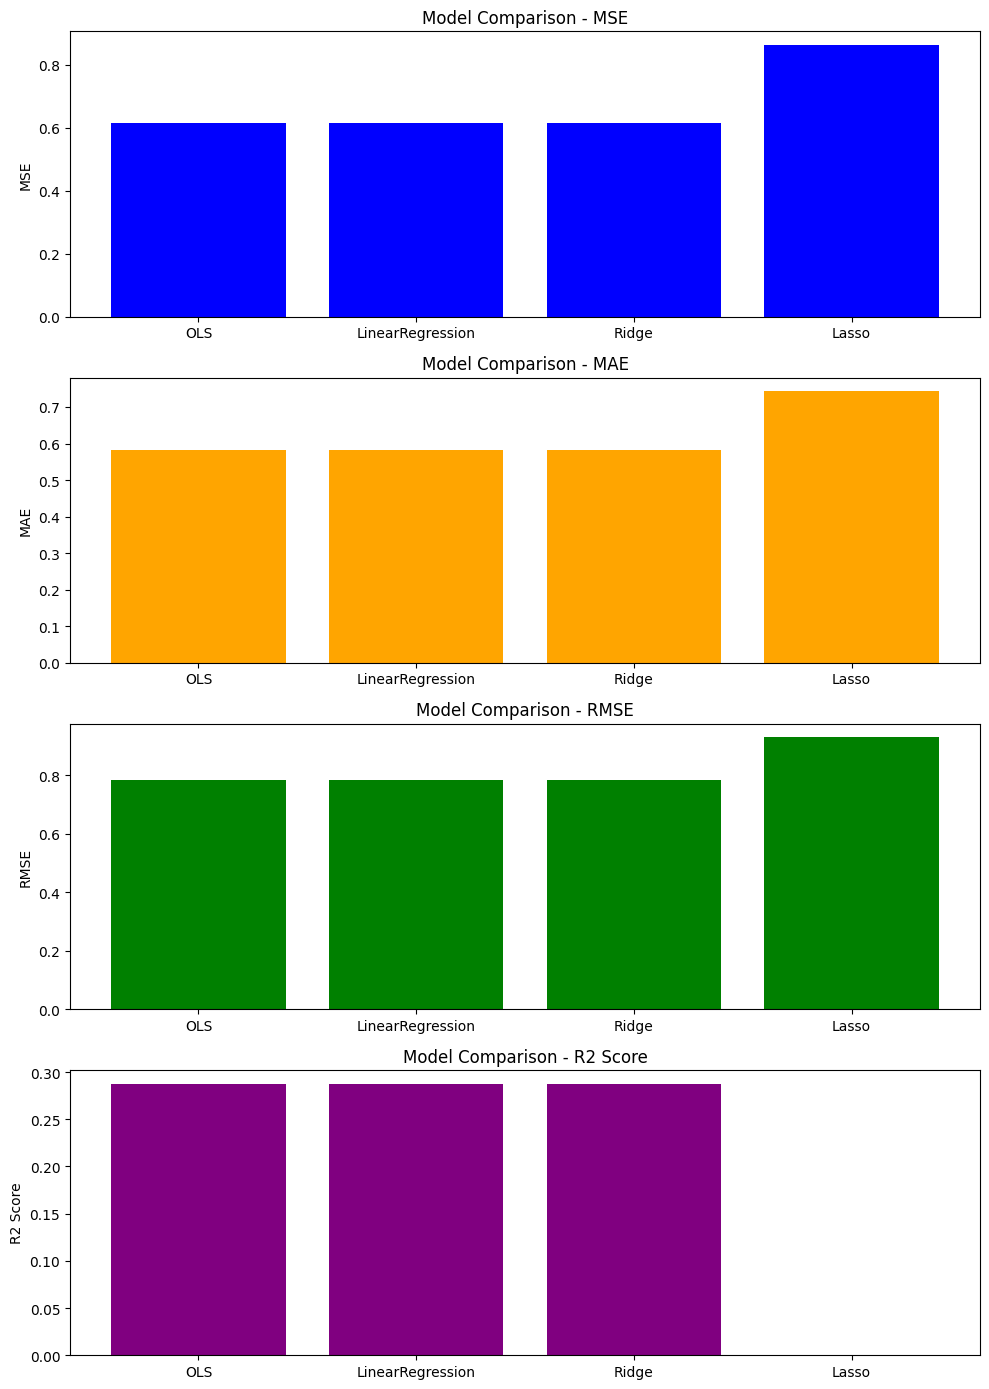

In [40]:
fig, ax = pyplt.subplots(4, 1, figsize=(10, 14))

mse_val_res = [All_models_results[name]['MSE'] for name in All_models_results]
mae_val_res = [All_models_results[name]['MAE'] for name in All_models_results]
rmse_val_res = [All_models_results[name]['RMSE'] for name in All_models_results]
r2_val_res = [All_models_results[name]['R2'] for name in All_models_results]
# Plot MSE comparison
ax[0].bar(All_models_results.keys(), mse_val_res, color='blue')
ax[0].set_title('Model Comparison - MSE')
ax[0].set_ylabel('MSE')

# Plot MAE comparison
ax[1].bar(All_models_results.keys(), mae_val_res, color='orange')
ax[1].set_title('Model Comparison - MAE')
ax[1].set_ylabel('MAE')
# Plot RMSE comparison
ax[2].bar(All_models_results.keys(), rmse_val_res, color='green')
ax[2].set_title('Model Comparison - RMSE')
ax[2].set_ylabel('RMSE')
# Plot R2 comparison
ax[3].bar(All_models_results.keys(), r2_val_res, color='purple')
ax[3].set_title('Model Comparison - R2 Score')
ax[3].set_ylabel('R2 Score')
pyplt.tight_layout()
pyplt.show()

# Test Cases

Test Case 1:

Episodes: 100

Popularity: 500

Ranked: 600

Premiered: 750

All other features are set to 0.

Test Case 2:

Episodes: 12

Popularity: 200

Ranked: 200

Premiered: 400

All other features are set to 0.